In [5]:
from params import *
from scipy.integrate import solve_ivp
import h5py
import pylab as pl
pl.style.use('latexplot')

In [6]:
f0 = np.sqrt(0.5/np.pi) / sigma * np.exp(-1/2 * ((r - 1)/sigma)**2)
def minmod(x, y, z):

    min_of_all = np.minimum(np.minimum(abs(x), abs(y)), abs(z))

    signx = np.sign(x)
    signy = np.sign(y)
    signz = np.sign(z)
    
    result = 0.25 * abs(signx + signy) * (signx + signz) * min_of_all
    return result

def slope_minmod(input_array):
    """
    Reconstructs the input array using a 
    minmod limiter.

    Parameters
    ----------
    
    input_array: np.array
                 Array holding the cells data.
    """
    f_i_plus_one  = np.roll(input_array, -1)
    f_i_minus_one = np.roll(input_array,  1)
  
    forward_diff  = (f_i_plus_one - input_array  )
    backward_diff = (input_array  - f_i_minus_one)
    central_diff  = backward_diff + forward_diff

    # Sort of user controlled:
    slope_lim_theta = 2

    left   = slope_lim_theta * backward_diff
    center = 0.5 * central_diff
    right  = slope_lim_theta * forward_diff

    return(minmod(left, center, right))

def reconstruct_minmod(variable_to_reconstruct):
    
    slope = slope_minmod(variable_to_reconstruct)

    left_face_value  = variable_to_reconstruct - 0.5 * slope
    right_face_value = variable_to_reconstruct + 0.5 * slope
   
    return(left_face_value, right_face_value)

def riemann_solver(left_state, right_state, velocity):
    upwind_state = np.select([velocity >= 0, velocity < 0], 
                             [left_state, right_state]
                            )
    return upwind_state

# Set this as 'instantaneous', linear', 'quadratic', 'sqrt', 'sigmoid'
def injection_term(t, inj_type, delta_cinj, tinj_start, tinj_end):
    if(inj_type == 'zero'):
        return 0
    elif(inj_type == 'instantaneous'):
        if(t < tinj_start):
            return 0
        else:
            return delta_cinj
    elif(inj_type == 'linear'):
        if(t < tinj_start):
            return 0
        elif(t > tinj_end):
            return delta_cinj
        else:
            return ((t - tinj_start) / (tinj_end - tinj_start)) * delta_cinj
    elif(inj_type == 'quadratic'):
        if(t < tinj_start):
            return 0
        elif(t > tinj_end):
            return delta_cinj
        else:
            return ((t - tinj_start) / (tinj_end - tinj_start))**2 * delta_cinj
    elif(inj_type == 'sqrt'):
        if(t < tinj_start):
            return 0
        elif(t > tinj_end):
            return delta_cinj
        else:
            return np.sqrt((t - tinj_start) / (tinj_end - tinj_start)) * delta_cinj
    elif(inj_type == 'tanh'):
        if(t < tinj_start):
            return 0
        elif(t > tinj_end):
            return delta_cinj
        else:
            # set scale here:
            # determines how fast the growth happens
            scale = 5
            return delta_cinj * np.tanh(scale * (t - tinj_start) / (tinj_end - tinj_start))
    else:
        raise Exception('Invalid Option!!')

def df_dt(t, f, inj_type, delta_cinj, tinj_start, tinj_end):
    global cinfu
    cinfu  += beta * R0**3 * np.sum(f[:N_g] * r[:N_g]**3) * dr
    f[:N_g] = 0
    if(np.sum(f[-N_g:] * r[-N_g:]**3) * dr > 1e-8):
        raise Exception('Increase r_max!')
    
    f_left_plus_eps, f_right_minus_eps = reconstruct_minmod(f)
    f_left_minus_eps = np.roll(f_right_minus_eps, 1)

    cinf= injection_term(t, inj_type, delta_cinj, tinj_start, tinj_end) + cinfu - beta * R0**3 * np.sum(f[N_g:-N_g] * r[N_g:-N_g]**3) * dr
    # Checking that the injected solute never exceeds the saturated concentration:
    # Throws an error if the condition isn't satisfied
    assert(cinf <= cinfu - beta * R0**3 * np.sum(f0[N_g:-N_g] * r[N_g:-N_g]**3) * dr)
    
    velocity = (cinf - cs * np.exp(lcap / (R0 * r))) / (delta_C * (Da + r))
    f_left   = riemann_solver(f_left_minus_eps, 
                              f_left_plus_eps, 
                              velocity
                             )
    
    left_flux  = velocity * f_left
    right_flux = np.roll(left_flux, -1)
    
    df_dt = -(right_flux - left_flux) / dr
    return df_dt

In [7]:
def compute_mean_std(sol, t):
    mean = np.zeros(t.size)
    var  = np.zeros(t.size)
    
    for i in range(t.size):
        mean[i] = np.sum(r[N_g:-N_g] * (sol['y'])[N_g:-N_g, i]) * dr
        var[i] = np.sum((sol['y'])[N_g:-N_g, i] * (r[N_g:-N_g] - mean[i])**2) * dr
        
    return mean, np.sqrt(var)

In [8]:
# Studying influence of time of injection:
def df_dt1(t, f):
    return df_dt(t, f, 'linear', 20, 10, 100)
def df_dt2(t, f):
    return df_dt(t, f, 'linear', 20, 10, 150)
def df_dt3(t, f):
    return df_dt(t, f, 'linear', 20, 10, 200)
def df_dt4(t, f):
    return df_dt(t, f, 'linear', 20, 10, 300)

In [9]:
sol1 = solve_ivp(df_dt1, (0, t_final), f0, t_eval=t_eval)
sol2 = solve_ivp(df_dt2, (0, t_final), f0, t_eval=t_eval)
sol3 = solve_ivp(df_dt3, (0, t_final), f0, t_eval=t_eval)
sol4 = solve_ivp(df_dt4, (0, t_final), f0, t_eval=t_eval)

In [10]:
mean1, std1 = compute_mean_std(sol1, t_eval)
mean2, std2 = compute_mean_std(sol2, t_eval)
mean3, std3 = compute_mean_std(sol3, t_eval)
mean4, std4 = compute_mean_std(sol4, t_eval)

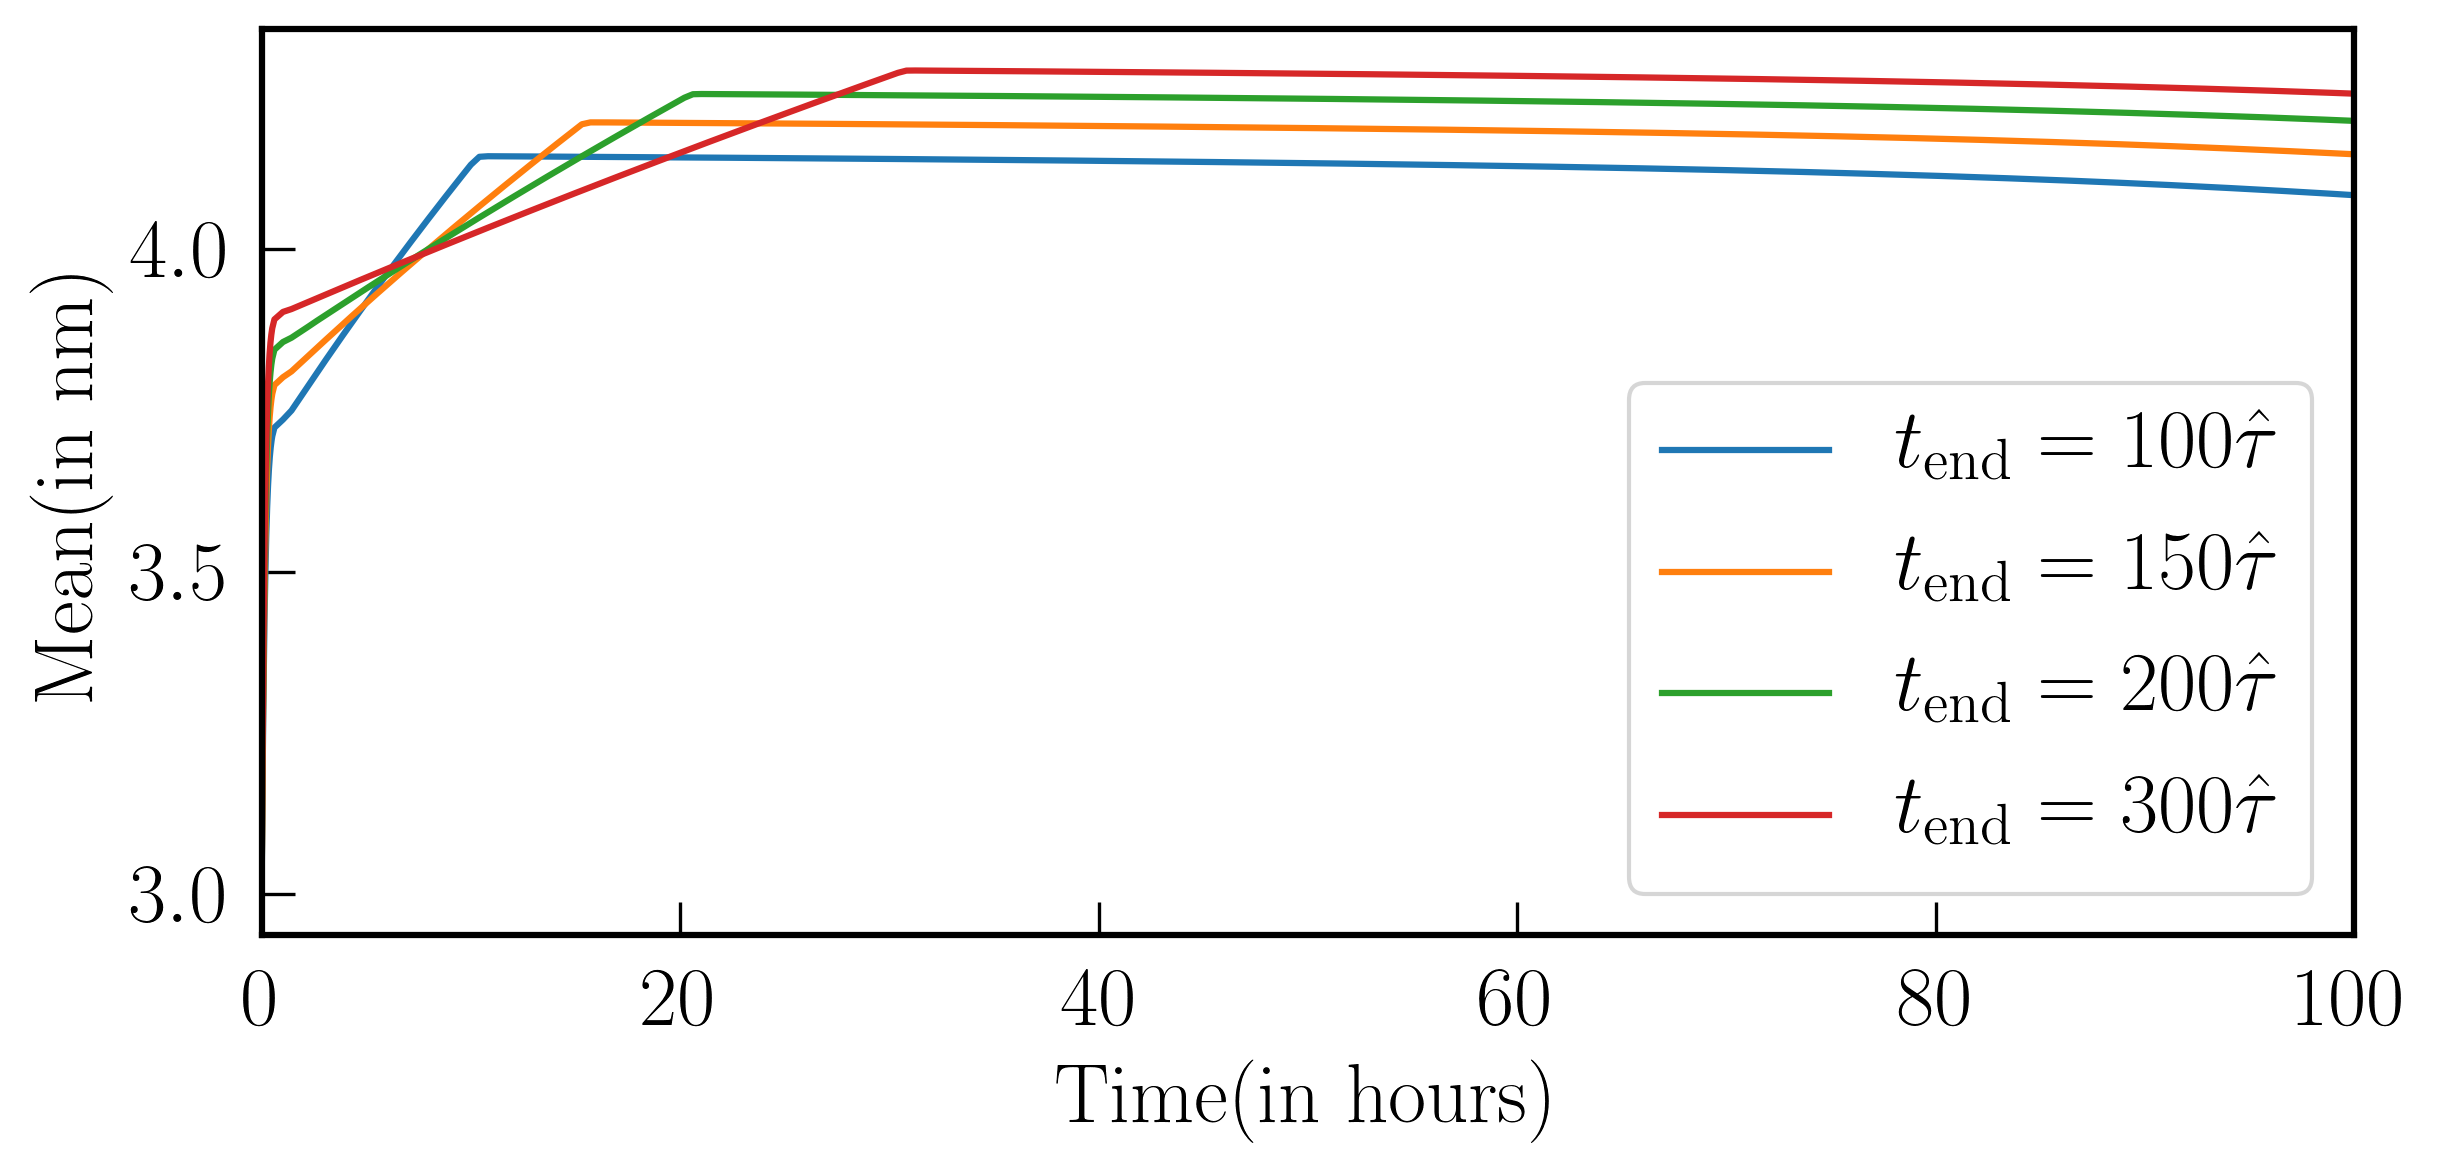

In [11]:
pl.plot(t_eval * (t0/3600), mean1 * R0/1e-9, label = r'$t_{\mathrm{end}} = 100\hat{\tau}$')
pl.plot(t_eval * (t0/3600), mean2 * R0/1e-9, label = r'$t_{\mathrm{end}} = 150\hat{\tau}$')
pl.plot(t_eval * (t0/3600), mean3 * R0/1e-9, label = r'$t_{\mathrm{end}} = 200\hat{\tau}$')
pl.plot(t_eval * (t0/3600), mean4 * R0/1e-9, label = r'$t_{\mathrm{end}} = 300\hat{\tau}$')
pl.xlabel('Time(in hours)')
pl.ylabel('Mean(in nm)')
pl.xlim(0, 100)
pl.legend()

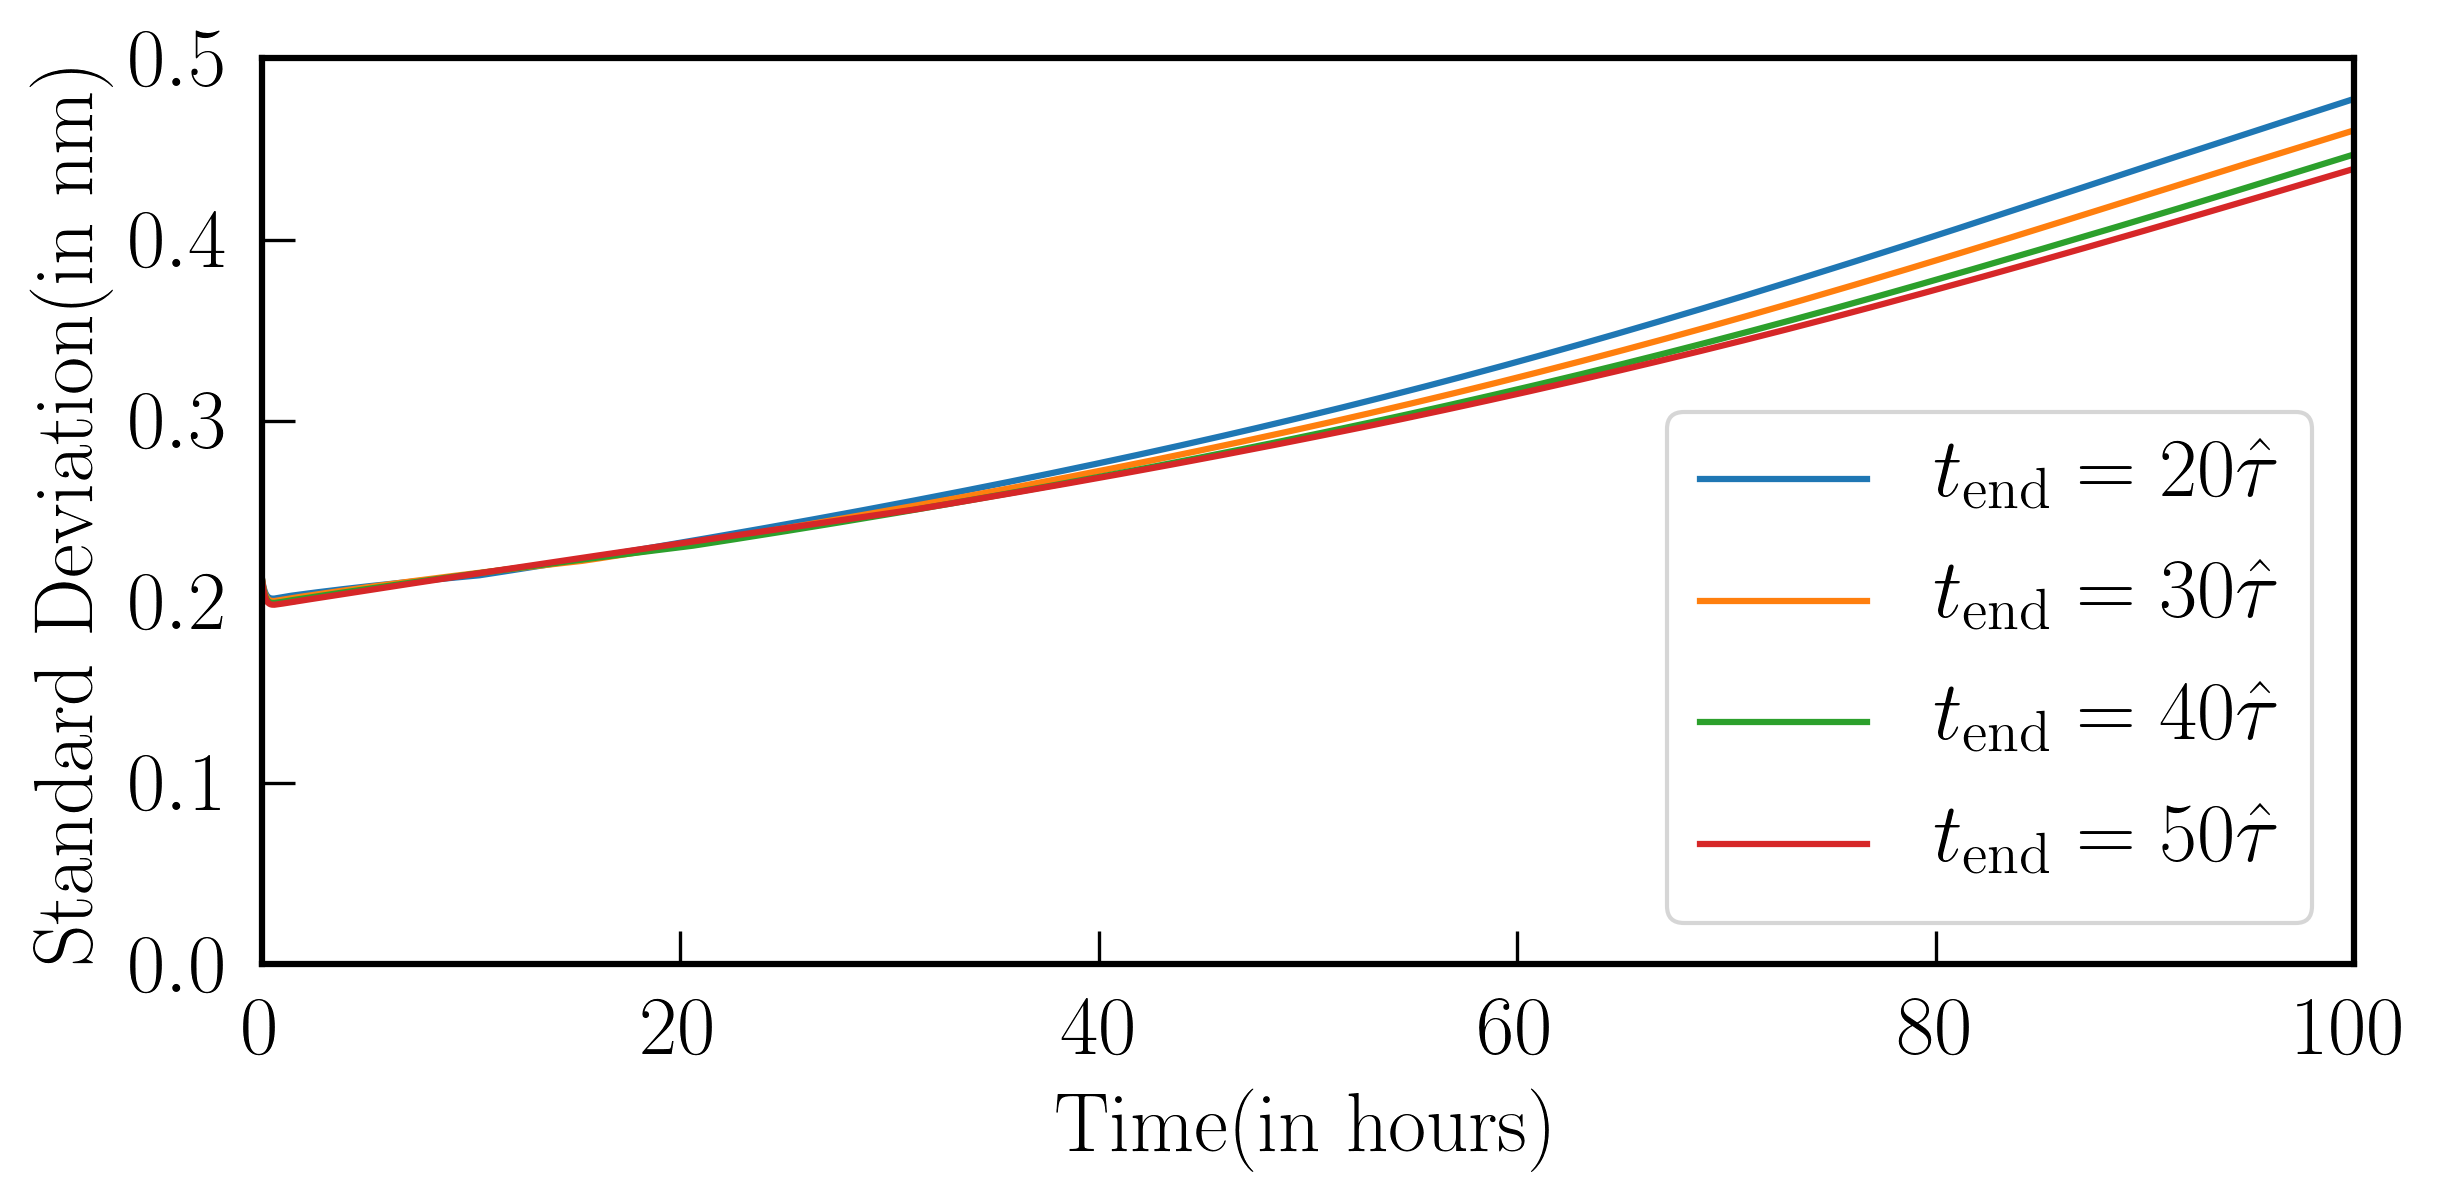

In [12]:
pl.plot(t_eval * (t0/3600), std1 * R0/1e-9, label = r'$t_{\mathrm{end}} = 20\hat{\tau}$')
pl.plot(t_eval * (t0/3600), std2 * R0/1e-9, label = r'$t_{\mathrm{end}} = 30\hat{\tau}$')
pl.plot(t_eval * (t0/3600), std3 * R0/1e-9, label = r'$t_{\mathrm{end}} = 40\hat{\tau}$')
pl.plot(t_eval * (t0/3600), std4 * R0/1e-9, label = r'$t_{\mathrm{end}} = 50\hat{\tau}$')
pl.xlabel('Time(in hours)')
pl.ylabel('Standard Deviation(in nm)')
pl.xlim(0, 100)
pl.ylim(0, .5)
pl.legend()

In [13]:
# Studying influence of mass of injection:
def df_dt1(t, f):
    return df_dt(t, f, 'linear', 5, 10, 50)
def df_dt2(t, f):
    return df_dt(t, f, 'linear', 10, 10, 50)
def df_dt3(t, f):
    return df_dt(t, f, 'linear', 20, 10, 50)
def df_dt4(t, f):
    return df_dt(t, f, 'linear', 40, 10, 50)

In [14]:
sol1 = solve_ivp(df_dt1, (0, t_final), f0, t_eval=t_eval)
sol2 = solve_ivp(df_dt2, (0, t_final), f0, t_eval=t_eval)
sol3 = solve_ivp(df_dt3, (0, t_final), f0, t_eval=t_eval)
sol4 = solve_ivp(df_dt4, (0, t_final), f0, t_eval=t_eval)

In [15]:
mean1, std1 = compute_mean_std(sol1, t_eval)
mean2, std2 = compute_mean_std(sol2, t_eval)
mean3, std3 = compute_mean_std(sol3, t_eval)
mean4, std4 = compute_mean_std(sol4, t_eval)

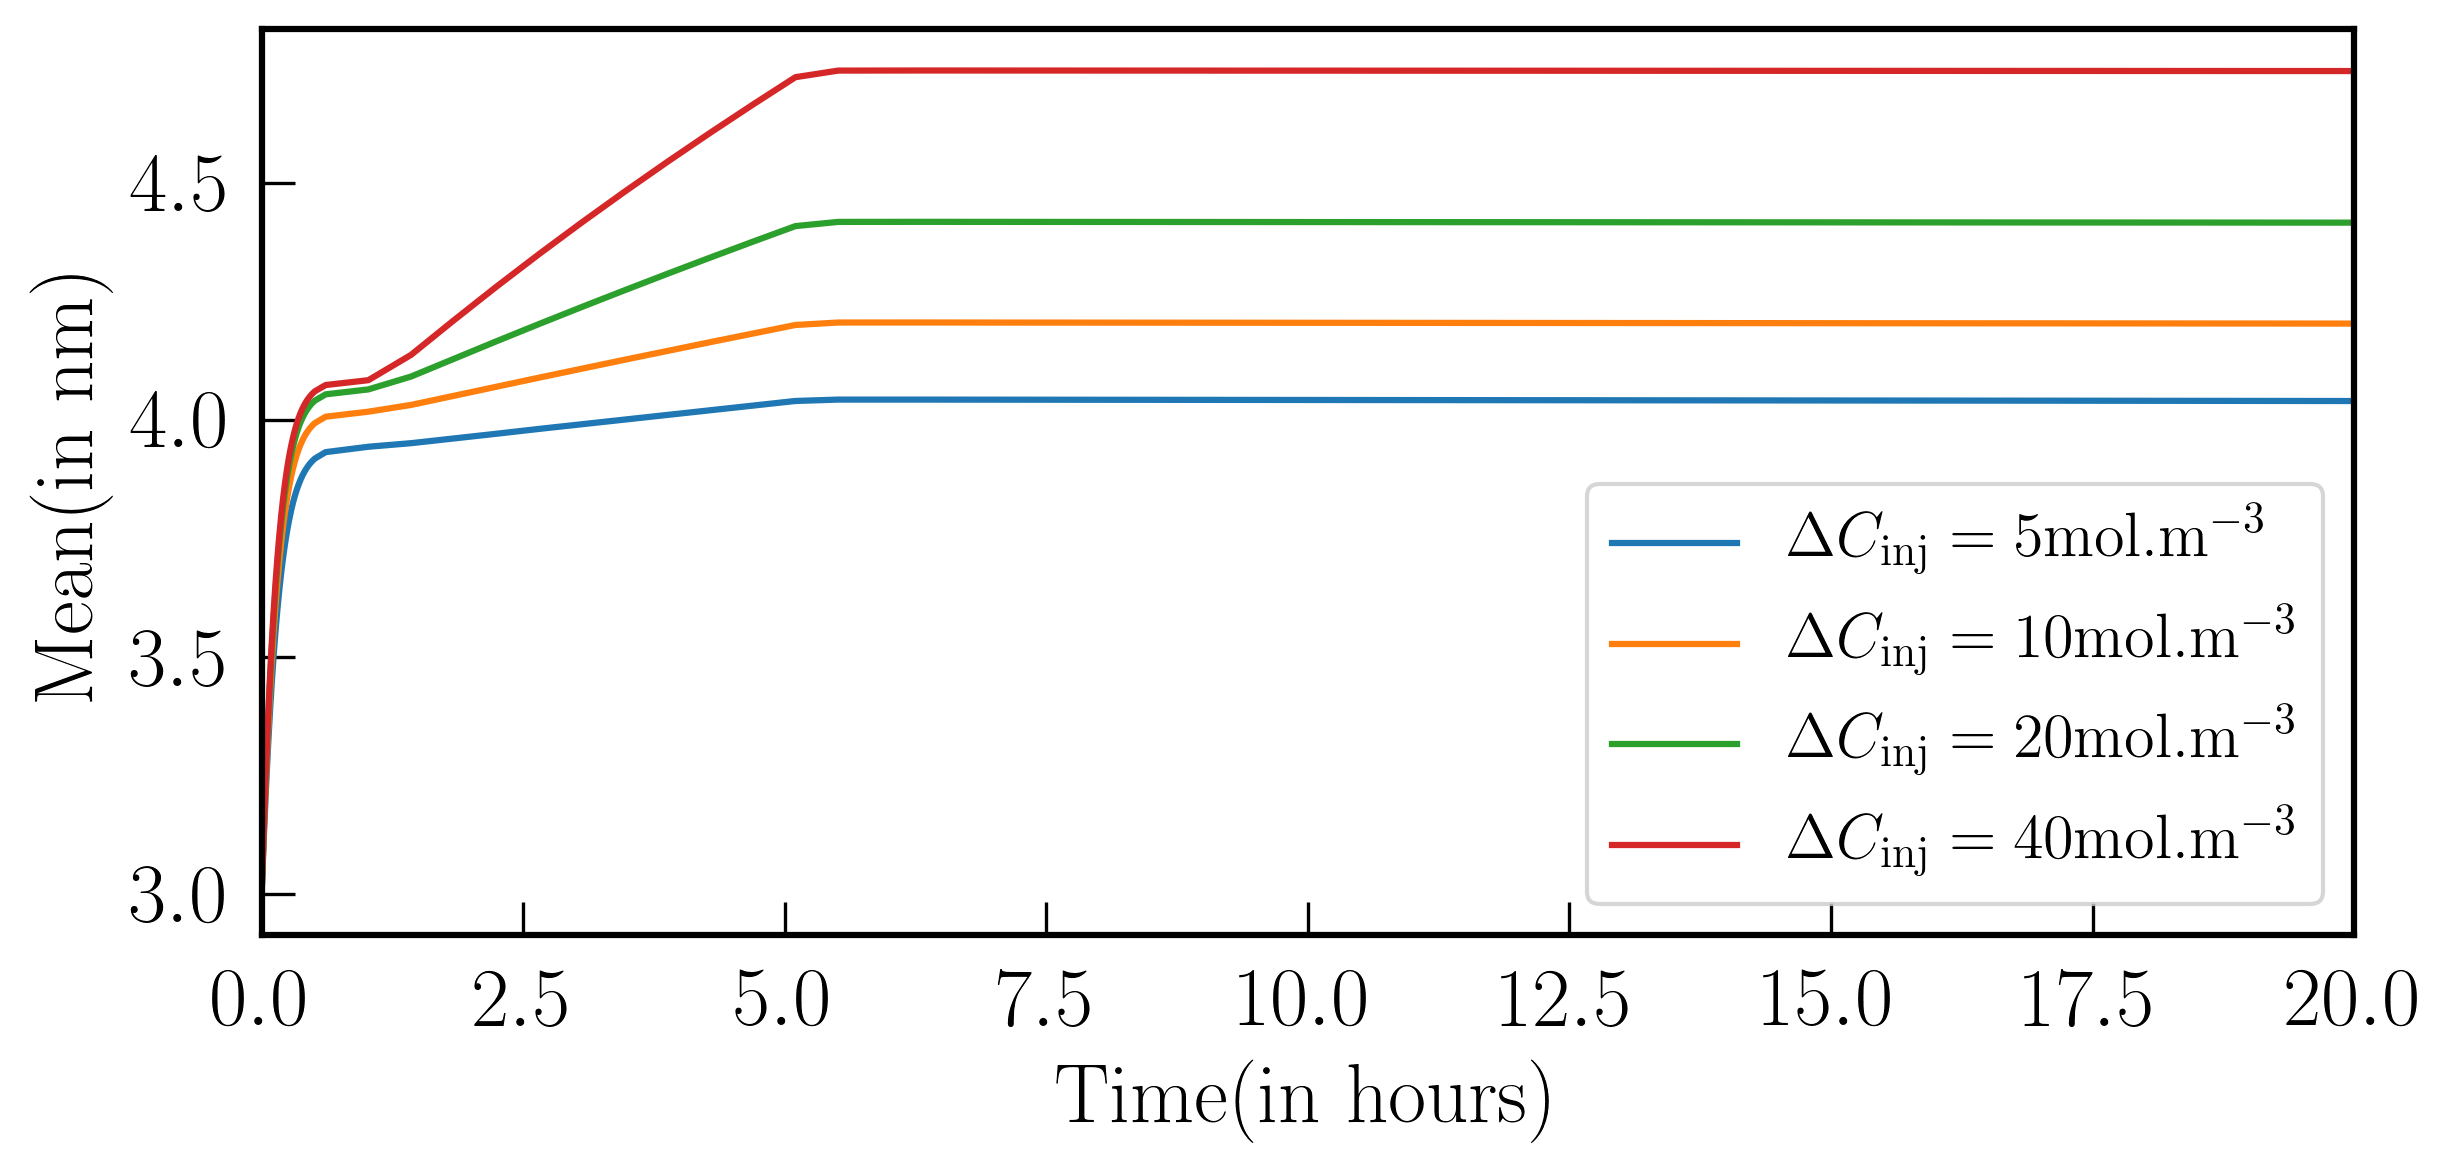

In [18]:
pl.plot(t_eval * (t0/3600), mean1 * R0/1e-9, label = r'$\Delta C_{\mathrm{inj}} = 5\mathrm{mol.m^{-3}}$')
pl.plot(t_eval * (t0/3600), mean2 * R0/1e-9, label = r'$\Delta C_{\mathrm{inj}} = 10\mathrm{mol.m^{-3}}$')
pl.plot(t_eval * (t0/3600), mean3 * R0/1e-9, label = r'$\Delta C_{\mathrm{inj}} = 20\mathrm{mol.m^{-3}}$')
pl.plot(t_eval * (t0/3600), mean4 * R0/1e-9, label = r'$\Delta C_{\mathrm{inj}} = 40\mathrm{mol.m^{-3}}$')
pl.xlabel('Time(in hours)')
pl.ylabel('Mean(in nm)')
pl.xlim(0, 20)
pl.legend(fontsize = 15)

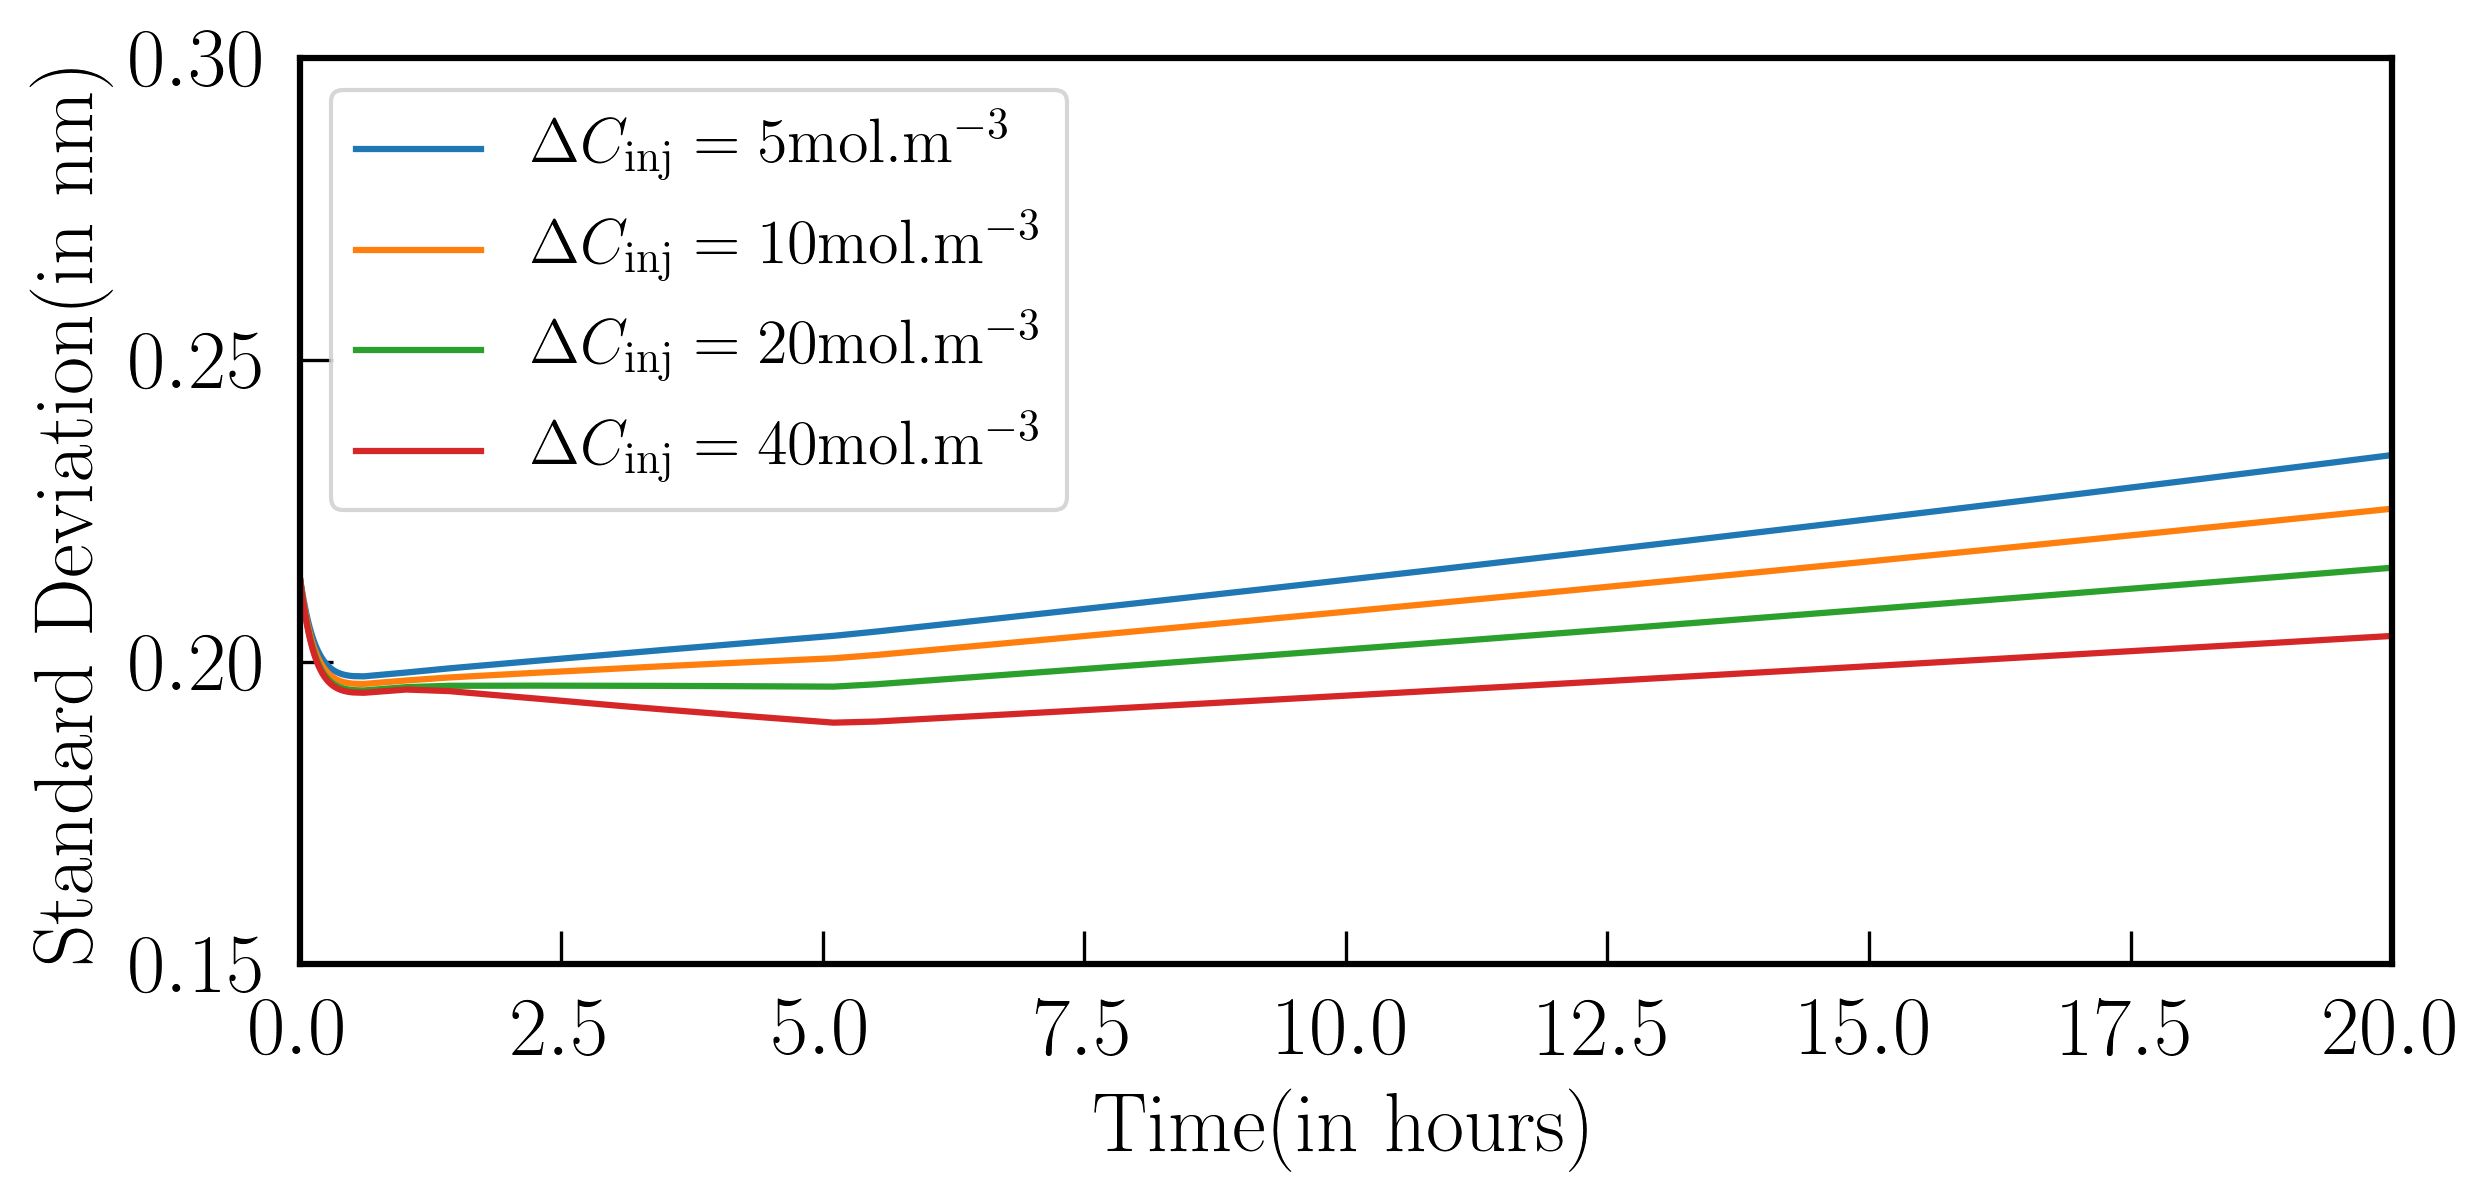

In [21]:
pl.plot(t_eval * (t0/3600), std1 * R0/1e-9, label = r'$\Delta C_{\mathrm{inj}} = 5\mathrm{mol.m^{-3}}$')
pl.plot(t_eval * (t0/3600), std2 * R0/1e-9, label = r'$\Delta C_{\mathrm{inj}} = 10\mathrm{mol.m^{-3}}$')
pl.plot(t_eval * (t0/3600), std3 * R0/1e-9, label = r'$\Delta C_{\mathrm{inj}} = 20\mathrm{mol.m^{-3}}$')
pl.plot(t_eval * (t0/3600), std4 * R0/1e-9, label = r'$\Delta C_{\mathrm{inj}} = 40\mathrm{mol.m^{-3}}$')
pl.xlabel('Time(in hours)')
pl.ylabel('Standard Deviation(in nm)')
pl.xlim(0, 20)
pl.ylim(0.15, .3)
pl.legend(fontsize = 15)

In [42]:
def df_dt_linear(t, f):
    return df_dt(t, f, 'linear', 20, 10, 100)

def df_dt_quadratic(t, f):
    return df_dt(t, f, 'quadratic', 20, 10, 100)

def df_dt_sqrt(t, f):
    return df_dt(t, f, 'sqrt', 20, 10, 100)

def df_dt_tanh(t, f):
    return df_dt(t, f, 'tanh', 20, 10, 100)

In [43]:
sol1 = solve_ivp(df_dt_linear, (0, t_final), f0, t_eval=t_eval)
sol2 = solve_ivp(df_dt_quadratic, (0, t_final), f0, t_eval=t_eval)
sol3 = solve_ivp(df_dt_sqrt, (0, t_final), f0, t_eval=t_eval)
sol4 = solve_ivp(df_dt_tanh, (0, t_final), f0, t_eval=t_eval)

In [44]:
mean1, std1 = compute_mean_std(sol1, t_eval)
mean2, std2 = compute_mean_std(sol2, t_eval)
mean3, std3 = compute_mean_std(sol3, t_eval)
mean4, std4 = compute_mean_std(sol4, t_eval)

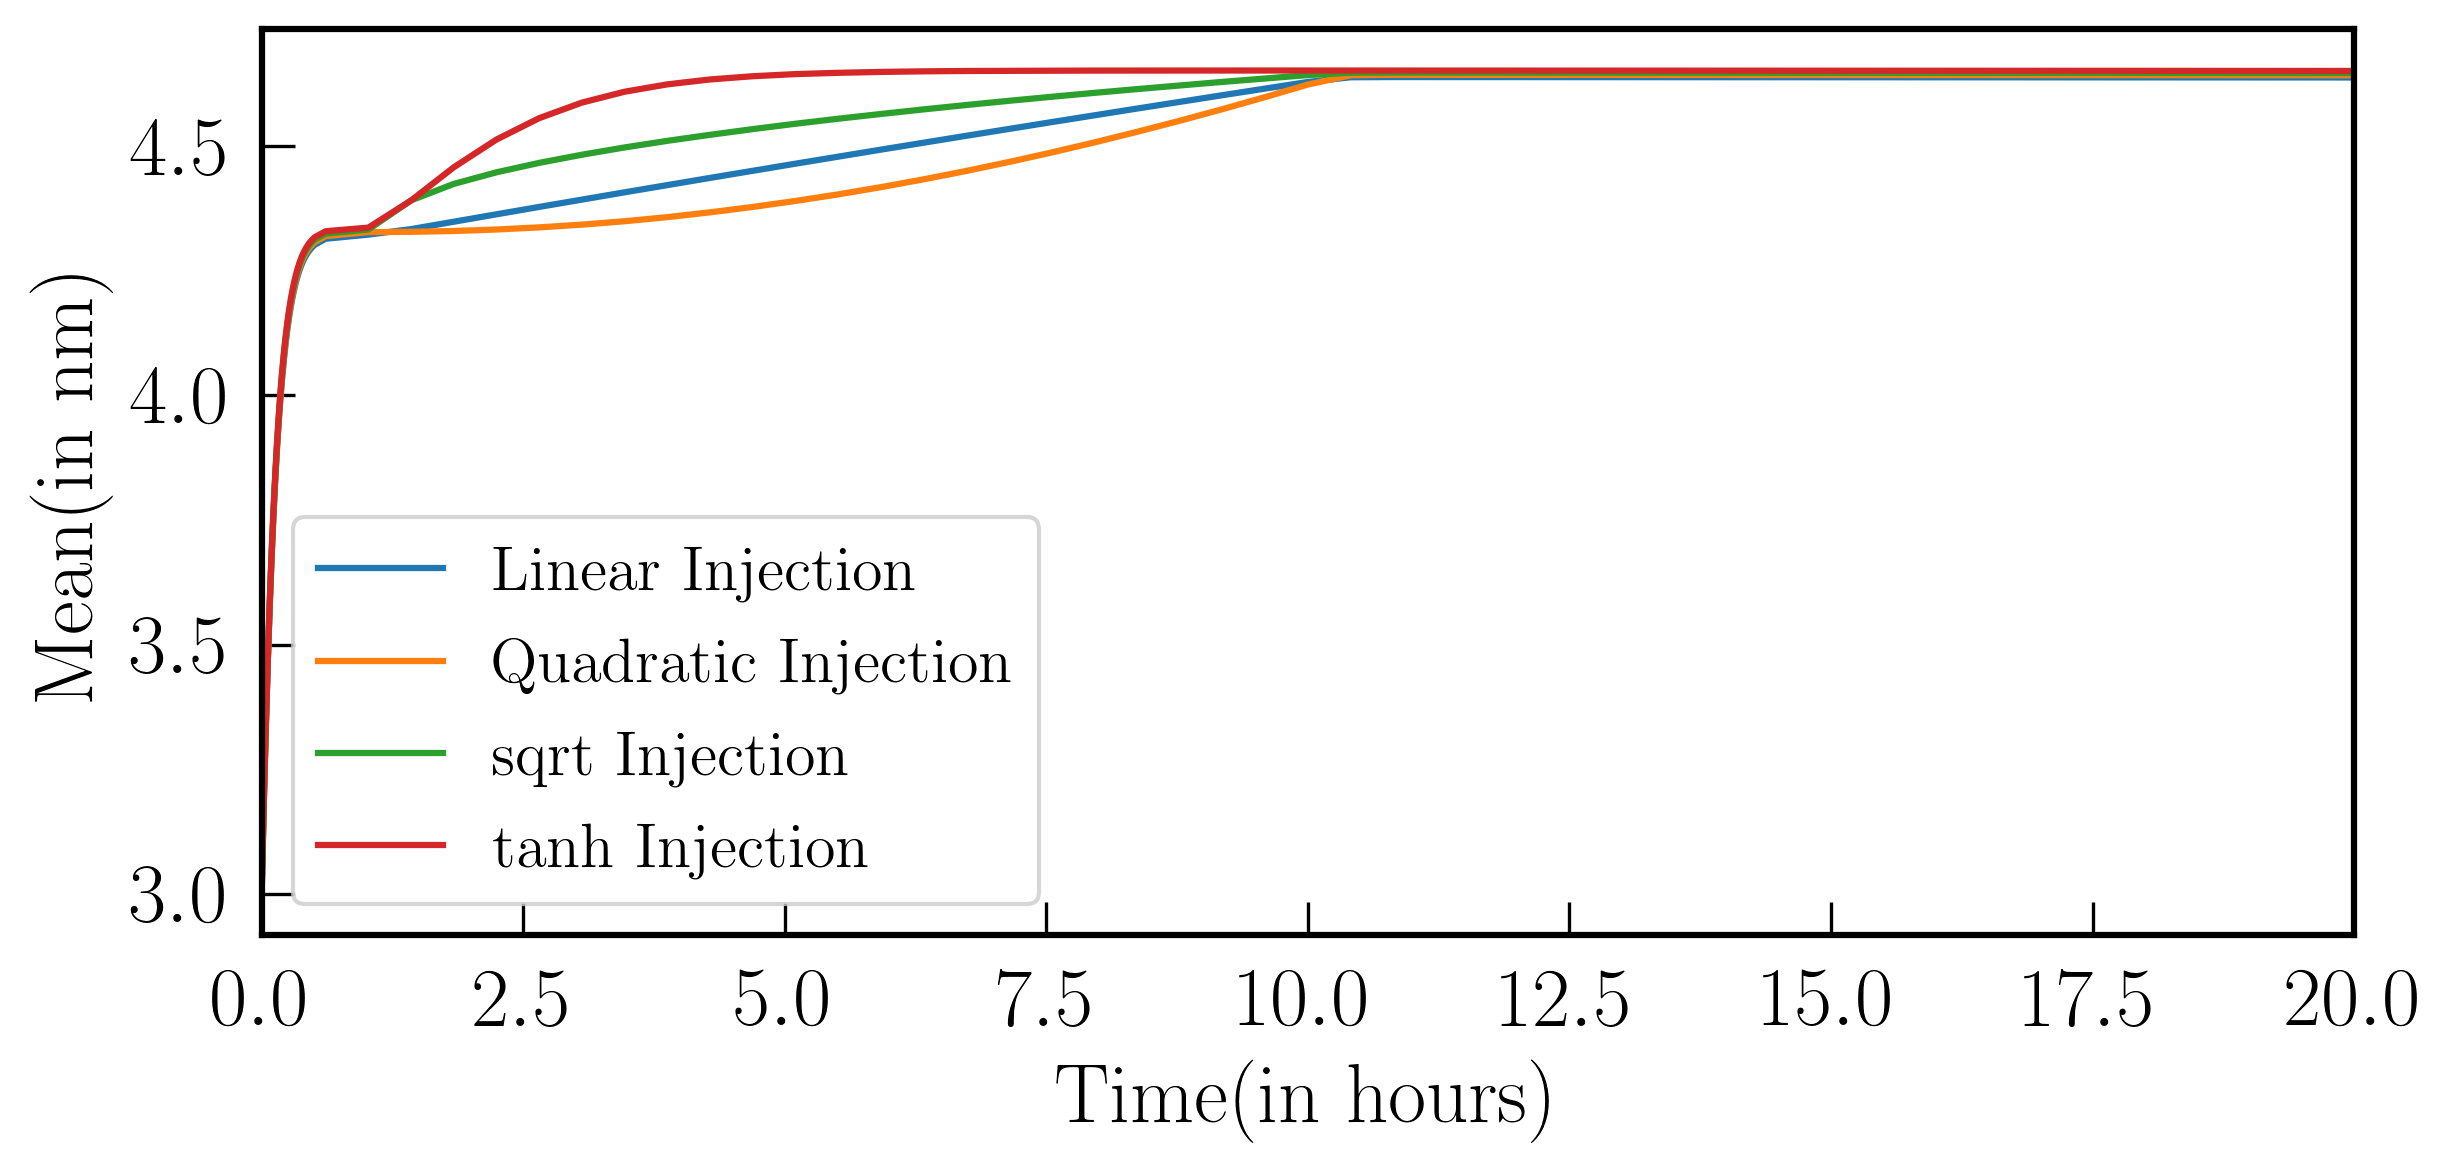

In [45]:
pl.plot(t_eval * (t0/3600), mean1 * R0/1e-9, label = r'Linear Injection')
pl.plot(t_eval * (t0/3600), mean2 * R0/1e-9, label = r'Quadratic Injection')
pl.plot(t_eval * (t0/3600), mean3 * R0/1e-9, label = r'$\mathrm{sqrt}$ Injection')
pl.plot(t_eval * (t0/3600), mean4 * R0/1e-9, label = r'$\tanh$ Injection')
pl.xlabel('Time(in hours)')
pl.ylabel('Mean(in nm)')
pl.xlim(0, 20)
pl.legend(fontsize = 15)

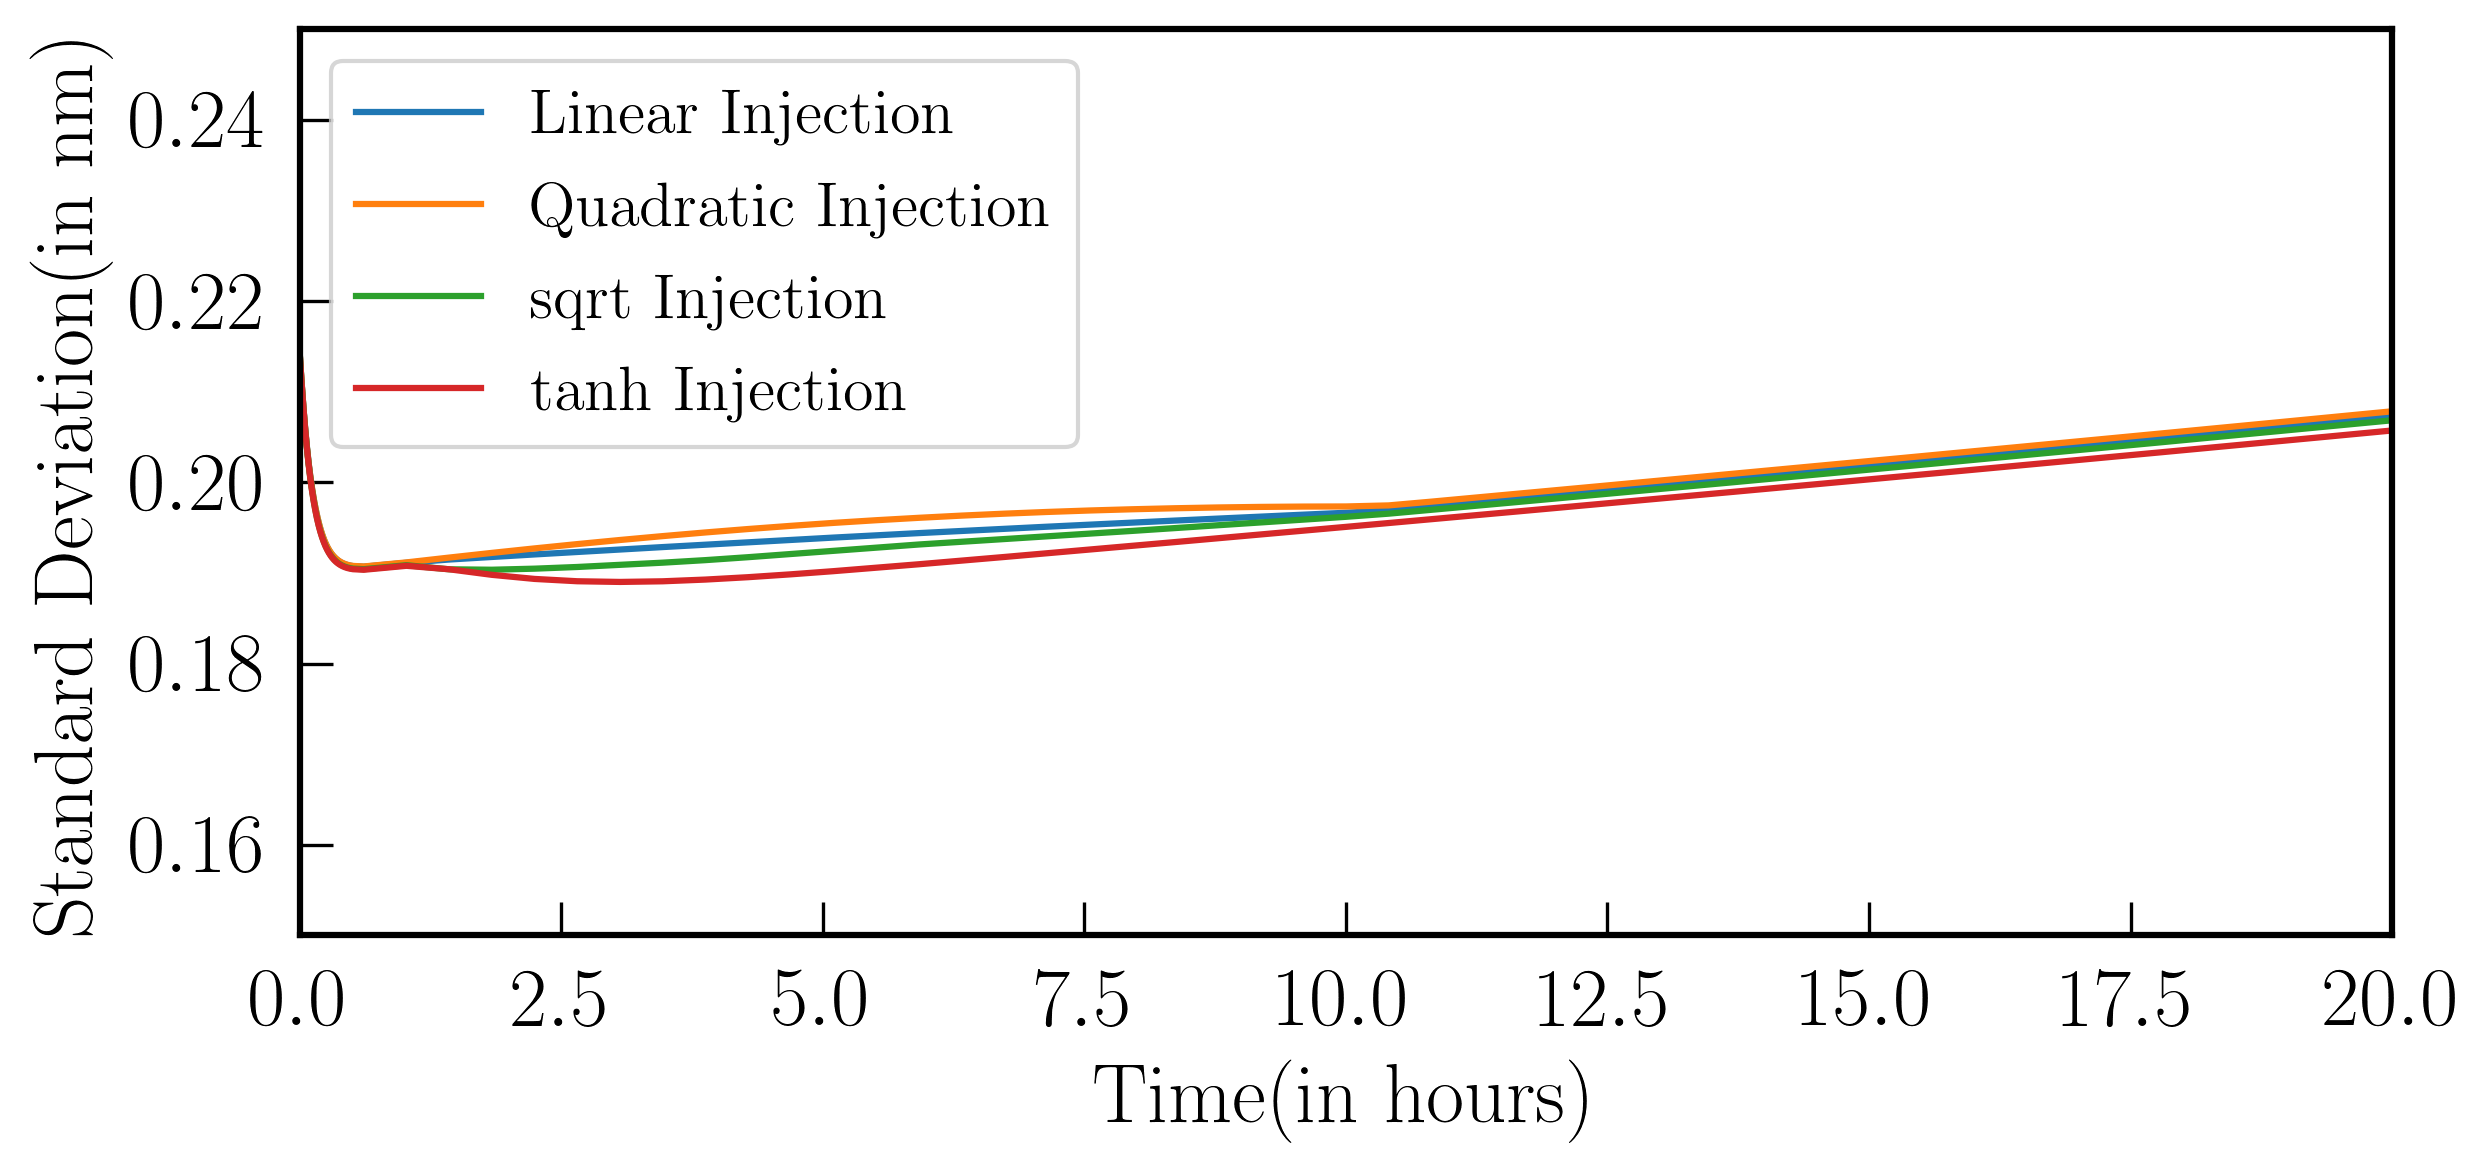

In [46]:
pl.plot(t_eval * (t0/3600), std1 * R0/1e-9, label = r'Linear Injection')
pl.plot(t_eval * (t0/3600), std2 * R0/1e-9, label = r'Quadratic Injection')
pl.plot(t_eval * (t0/3600), std3 * R0/1e-9, label = r'$\mathrm{sqrt}$ Injection')
pl.plot(t_eval * (t0/3600), std4 * R0/1e-9, label = r'$\tanh$ Injection')
pl.xlabel('Time(in hours)')
pl.ylabel('Standard Deviation(in nm)')
pl.xlim(0, 20)
pl.ylim(0.15, 0.25)
pl.legend(fontsize = 15)

Text(0, 0.5, '$\\hat{c}_{\\mathrm{inj}}$')

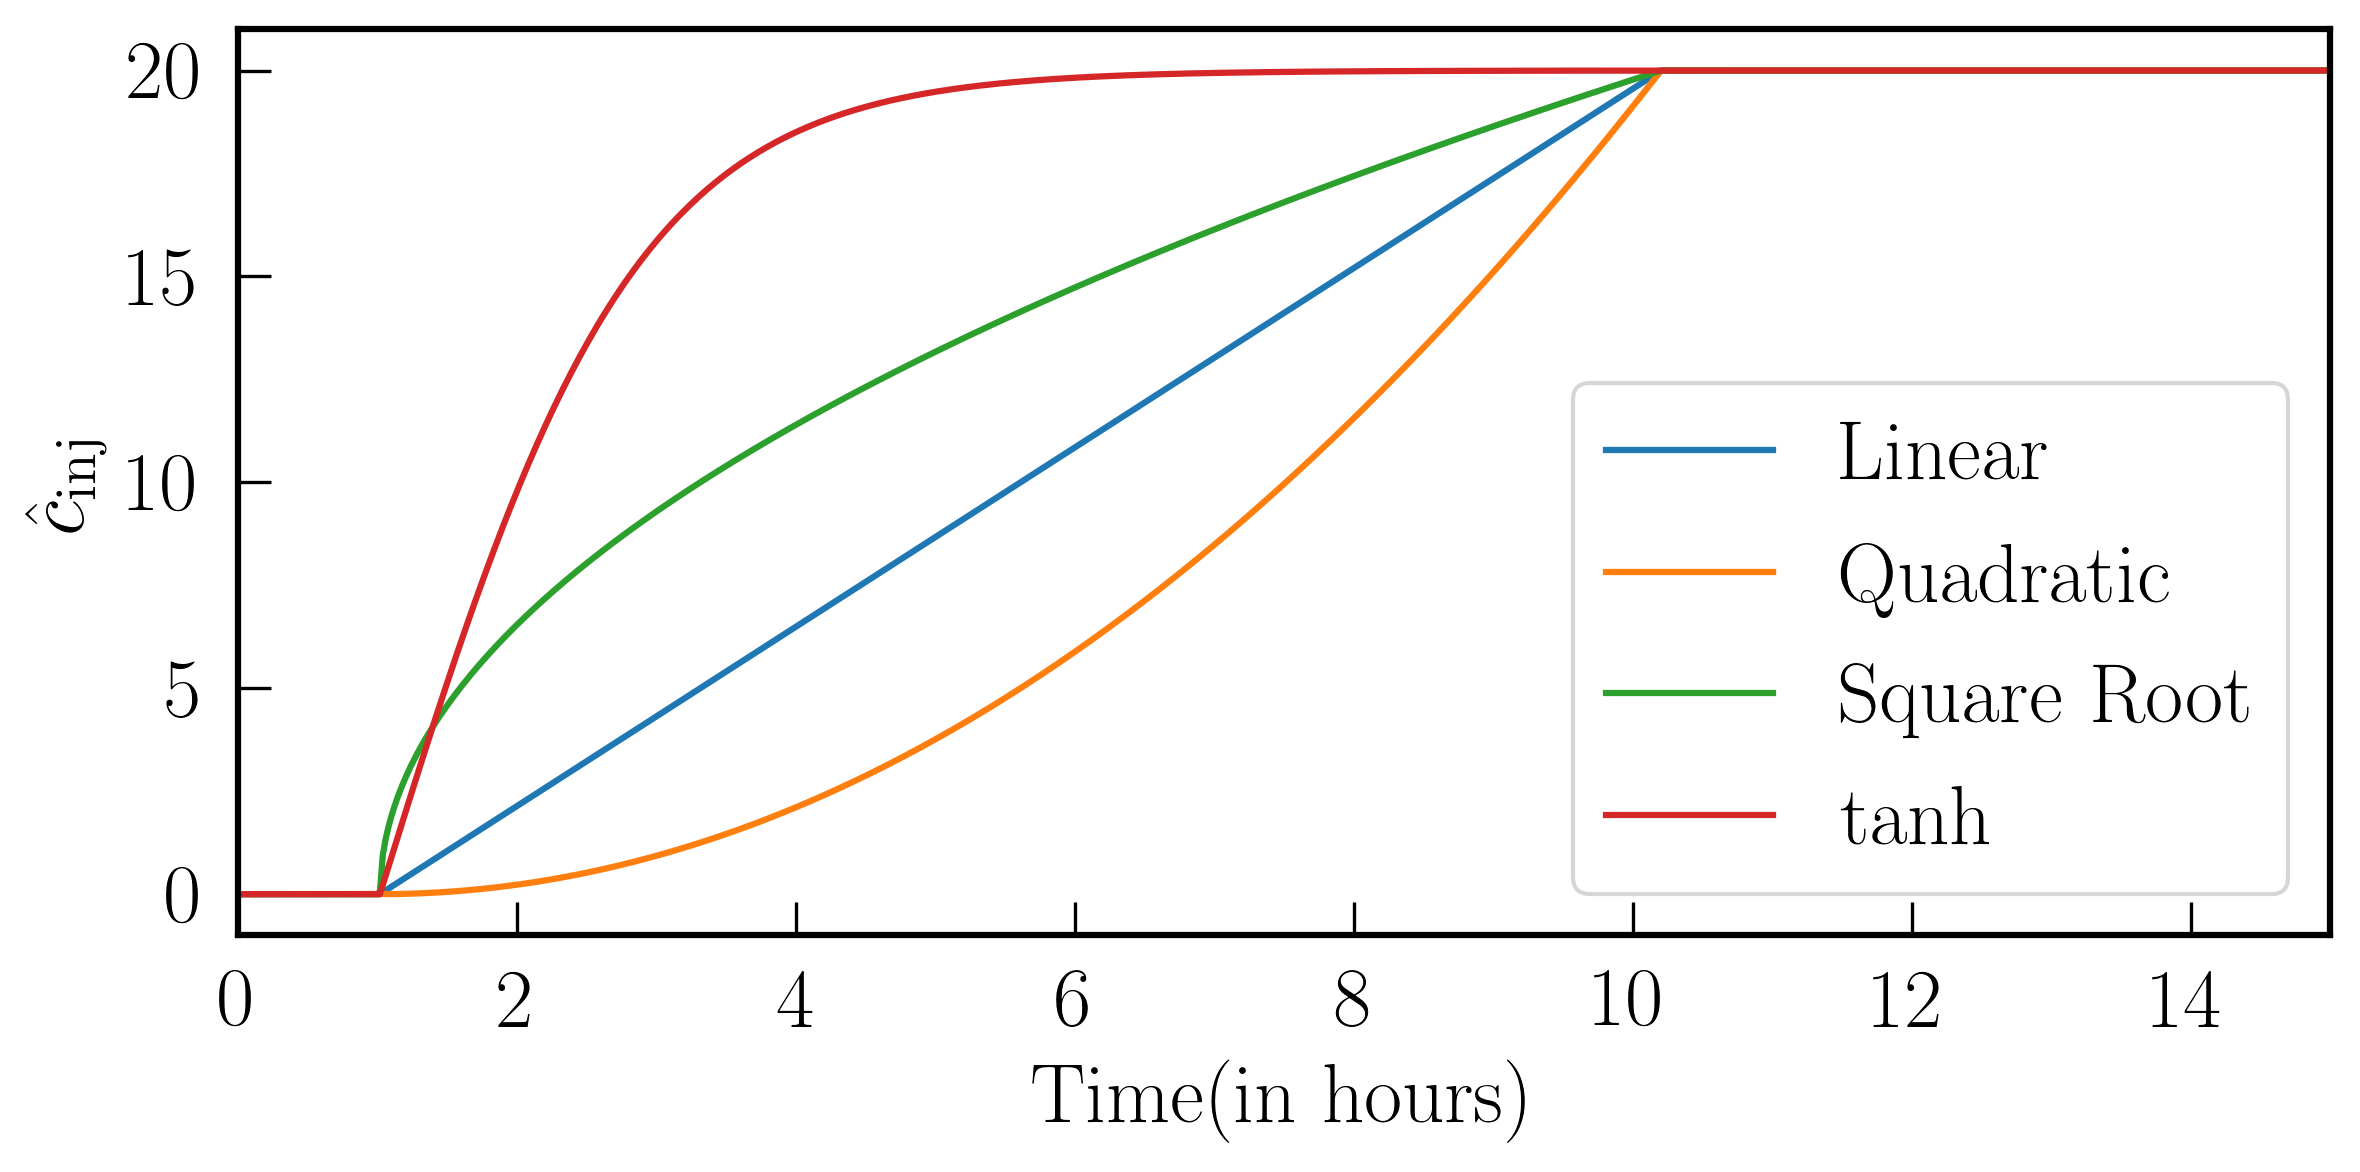

In [52]:
t = np.linspace(0, 2000, 10000)

arr1 = np.zeros(t.size)
arr2 = np.zeros(t.size)
arr3 = np.zeros(t.size)
arr4 = np.zeros(t.size)
arr5 = np.zeros(t.size)

for i in range(t.size):
    arr1[i] = injection_term(t[i], 'instantaneous', 20, 10, 100)
for i in range(t.size):
    arr2[i] = injection_term(t[i], 'linear', 20, 10, 100)
for i in range(t.size):
    arr3[i] = injection_term(t[i], 'quadratic', 20, 10, 100)
for i in range(t.size):
    arr4[i] = injection_term(t[i], 'sqrt', 20, 10, 100)
for i in range(t.size):
    arr5[i] = injection_term(t[i], 'tanh', 20, 10, 100)

# pl.plot(t, arr1, label = 'Heaviside')
pl.plot(t * (t0/3600), arr2, label = 'Linear')
pl.plot(t * (t0/3600), arr3, label = 'Quadratic')
pl.plot(t * (t0/3600), arr4, label = 'Square Root')
pl.plot(t * (t0/3600), arr5, label = '$\mathrm{tanh}$')
pl.legend()
# pl.plot(t, injection_term(t, 'instantaneous'))
# pl.plot(t, injection_term(t, 'linear'))
# pl.plot(t, injection_term(t, 'quadratic'))
# pl.plot(t, injection_term(t, 'sqrt'))
# pl.plot(t, injection_term(t, 'tanh'))
pl.xlim(0, 15)
pl.xlabel('Time(in hours)')
pl.ylabel(r'$\hat{c}_{\mathrm{inj}}$')

In [ ]:
t0 / 3600